### Plot Mixed Layer Depth

In [1]:
# mom6_tools
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import myStats, annotateStats

import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import xarray as xr
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import warnings, os, yaml
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
diag_config_yml = yaml.load(open('diag_config_comparison.yml','r'),
                            Loader=yaml.Loader)

In [3]:
# initialize lists
dcase = []; casename=[]
label = []; outdir=[]
ncfiles=[]
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ncfiles.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    outdir.append(dcase.get_value('RUNDIR'))
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ncfiles.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      outdir.append(dcase.get_value('RUNDIR'))
    
# set avg dates
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']

In [4]:
ncfiles

['/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022b/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022c/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022d/ncfiles/']

In [5]:
# load grid and pre-difined masks
grd = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


In [6]:
lab_sea_mask = (basin_code.sel(region='LabSea').values* 1)

In [7]:
%matplotlib inline

for n in range(len(casename)):
  ds = xr.open_dataset(ncfiles[n]+casename[n]+'_MLD_winter.nc').MLD_winter
  sMin, sMax, sMean, sStd, sRMS = myStats(np.ma.masked_invalid(ds.values), 
                                        grd.area_t)    
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

  pc = ax.pcolormesh(grd.geolon_c, grd.geolat_c, ds,
                transform=ccrs.PlateCarree(),vmin=0, vmax=1000,
                cmap='coolwarm')
  ax.set_title(label[n] + ', '+ ds.description)
  annotateStats(ax, sMin, sMax, sMean, sStd, sRMS)

  cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
  cbar = plt.colorbar(pc, cax=cax, label='[m]')
  cbar.ax.tick_params(labelsize=12) 
  ax.set_global()
  ax.stock_img()
  ax.coastlines();
  fname='PNG/MLD_{}.png'.format(label[n])
  plt.savefig(fname)
  plt.close()

In [8]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


In [9]:
sMin, sMax, sMean, sStd, sRMS = myStats(obs_winter, grd.area_t)    
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

pc = ax.pcolormesh(grd.geolon_c, grd.geolat_c, obs_winter,
              transform=ccrs.PlateCarree(),vmin=0, vmax=1000,
              cmap='coolwarm')
ax.set_title('Winter MLD from de Boyer Montegut et al., JGR 2004')
annotateStats(ax, sMin, sMax, sMean, sStd, sRMS)

cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
cbar = plt.colorbar(pc, cax=cax, label='[m]')
cbar.ax.tick_params(labelsize=12) 
ax.set_global()
ax.stock_img()
ax.coastlines();
fname='PNG/MLD_obs.png'
plt.savefig(fname)
plt.close()

In [10]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46005/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46005/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.13:42120,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46005/status,Total threads: 0
Started: Just now,Total memory: 0 B


### MLD time series in the Lab Sea

In [11]:
lab_sea_mask = (basin_code.sel(region='LabSea').values* 1)
masked = np.ma.masked_where(lab_sea_mask==0, lab_sea_mask)
area_lab_sea = basin_code.sel(region='LabSea')*grd_xr.area_t

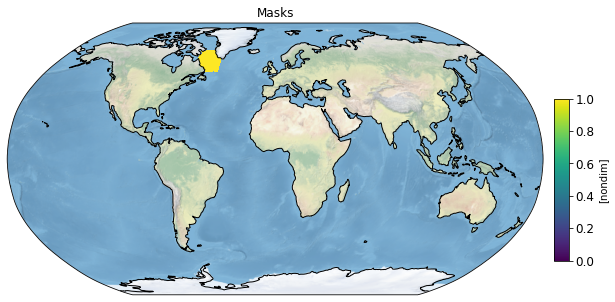

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

pc = ax.pcolormesh(grd.geolon, grd.geolat, masked,
              transform=ccrs.PlateCarree(),vmin=0, vmax=1)

ax.set_title('Masks')
cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
cbar = plt.colorbar(pc, cax=cax, label='[nondim]')
cbar.ax.tick_params(labelsize=12) 
ax.set_global()
ax.stock_img()
ax.coastlines();
fname='PNG/lab_sea_mask.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')

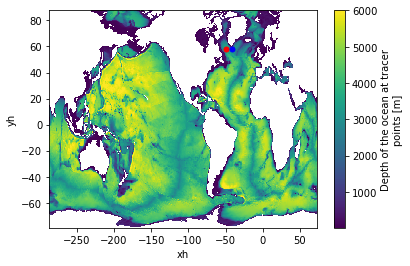

In [13]:
fig, ax = plt.subplots()
grd_xr.depth_ocean.plot(ax=ax)
dummy = grd_xr.depth_ocean.sel(xh = -50, yh = 58., method='nearest')
ax.plot(dummy.xh.values, dummy.yh.values, color='r', ms=5, marker='o');
dummy2 = grd_xr.depth_ocean.sel(xh = -42, yh = 58.5, method='nearest')
ax.plot(dummy2.xh.values, dummy2.yh.values, color='b', ms=5, marker='o');

In [14]:
def preprocess(ds):
    variables = ['mlotst']
    return ds[variables]

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022b
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022d


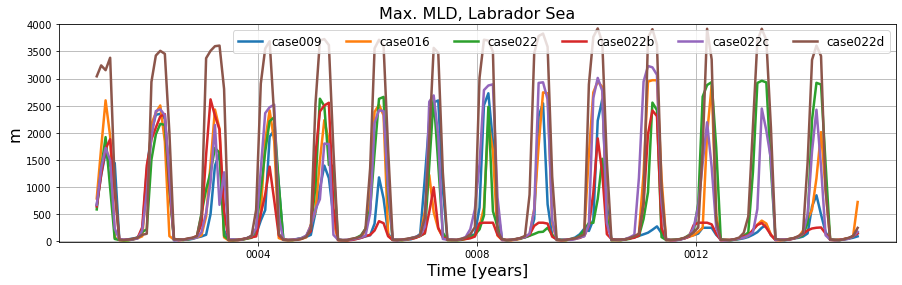

In [15]:
# load hm files 
fig = plt.figure(figsize=(15, 4))

for n in range(len(casename)):
  print(casename[n])
  ds = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
    
  #var = (ds.mlotst.sel(time=slice(start_date,
  #      end_date))*basin_code.sel(region='LabSea')).weighted(area_lab_sea).mean(("xh", "yh"))
  var = (ds.mlotst.sel(time=slice(start_date,
        end_date))*basin_code.sel(region='LabSea')).max(("xh", "yh"))
  #var = var.resample(time="1Y", closed='left').mean('time')
  plt.plot(var.time, var, label=label[n], lw=2.5)

plt.title('Max. MLD, Labrador Sea', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylim(-10,4000)
plt.ylabel(ds.mlotst.units, fontsize=16)
plt.grid()
plt.legend(fontsize=12, ncol=7);
fname='PNG/max_mld_time_series_lab_sea.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022b
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022d


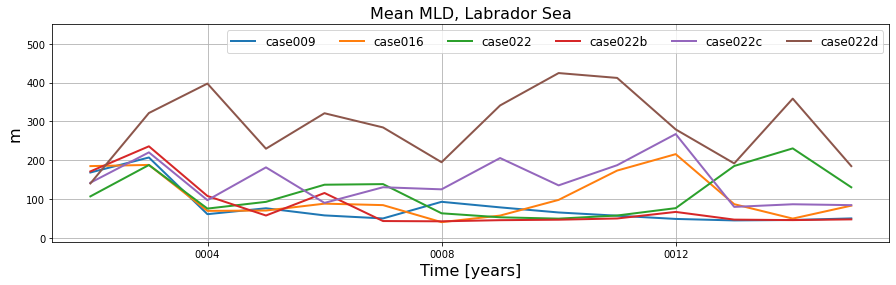

In [16]:
# load hm files 
fig = plt.figure(figsize=(15, 4))

for n in range(len(casename)):
  print(casename[n])
  ds = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
    
  var = (ds.mlotst.sel(time=slice(start_date,
        end_date))*basin_code.sel(region='LabSea')).weighted(area_lab_sea).mean(("xh", "yh"))
  var = var.resample(time="1Y", closed='left').mean('time')
  plt.plot(var.time, var, label=label[n], lw=2)

plt.title('Mean MLD, Labrador Sea', fontsize=16)
plt.ylim(-10,550)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds.mlotst.units, fontsize=16)
plt.grid()
plt.legend(fontsize=12, ncol=7);
fname='PNG/mean_mld_time_series_lab_sea.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022b
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022d


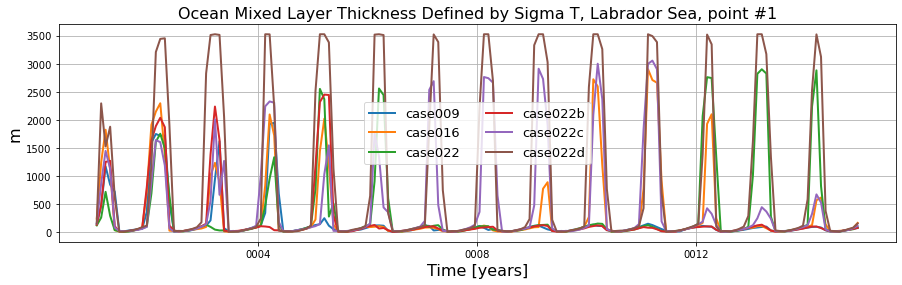

In [17]:
# load hm files
fig = plt.figure(figsize=(15, 4))

for n in range(len(casename)):
  print(casename[n])
  ds = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  var = ds.mlotst.sel(xh = -50, yh = 58., method='nearest').sel(time=slice(start_date,end_date))
  plt.plot(var.time, var, label=label[n], lw=2)

plt.title(var.long_name + ', Labrador Sea, point #1', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(var.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=2);
fname='PNG/mld_time_series_lab_sea_pt1.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022b
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L32_t061.camdev_cice5.022d


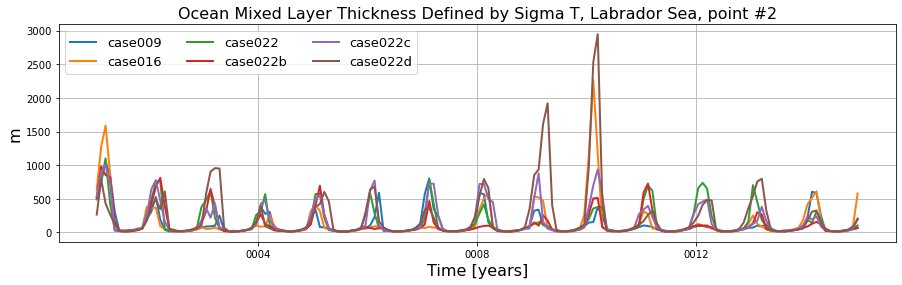

In [18]:
# load hm files
fig = plt.figure(figsize=(15, 4))

for n in range(len(casename)):
  print(casename[n])
  ds = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  var = ds.mlotst.sel(xh = -42, yh = 58.5, method='nearest').sel(time=slice(start_date,end_date))
  plt.plot(var.time, var, label=label[n], lw=2)

plt.title(var.long_name + ', Labrador Sea, point #2', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(var.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=3);
fname='PNG/mld_time_series_lab_sea_pt2.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')